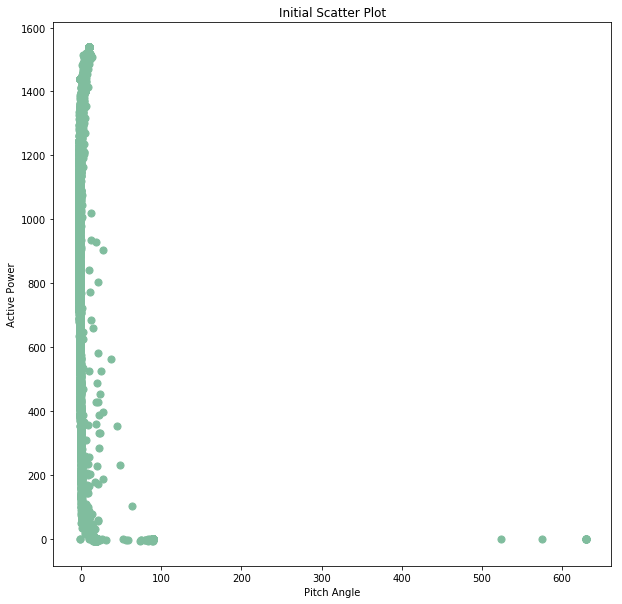

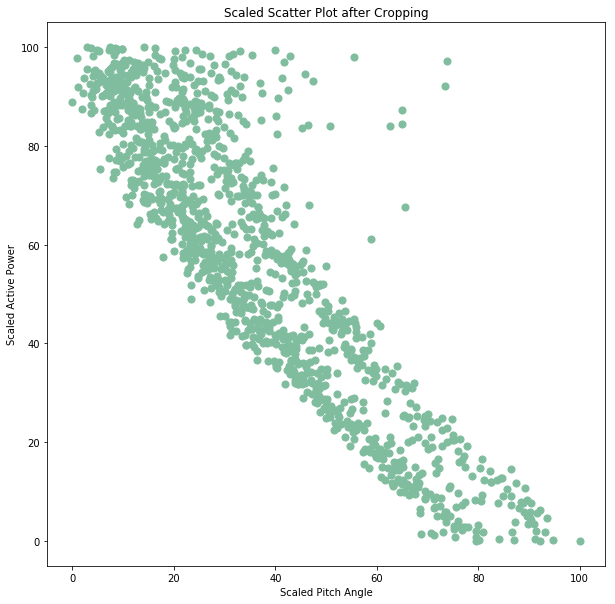

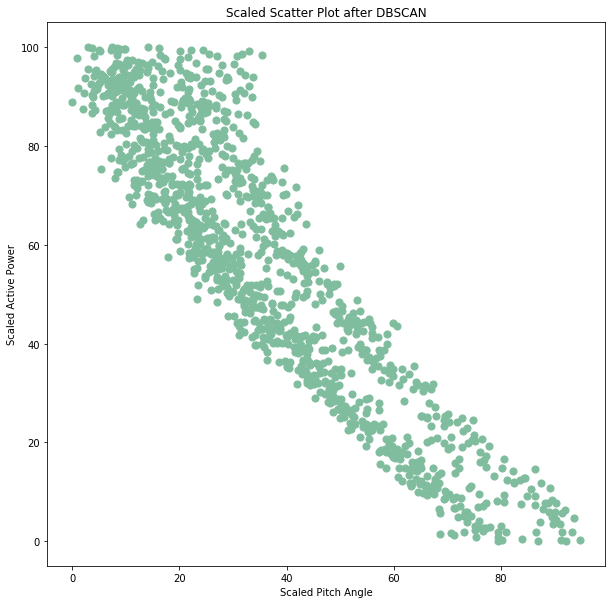

Function checking trends in PitchAngle vs ActivePower graph.
Arguments default to Chakla


{'filePath': './PvsAP/ScatterData_Chakla_C66.csv',
 'instances': 153,
 'machineType': 'DFIG',
 'maxInstances': 198,
 'maxScore': 1584,
 'maxScorePossible': 1224,
 'score': 1089.4713097048323}

In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import os

def rounding(mult=1, div=2):
    return lambda x: int((x * mult) / div)


def main(
    filePath,
    xMinFilter=-2.82,
    xMaxFilter=1.18,
    yMinFilter=188,
    yMaxFilter=1047,
    turbineStateFilter=11,
    dbscanEps=3,
    dbscanMinSamples=4,
    roundingMult=2,
    roundingDiv=1,
    maxSpacePositionLimits=(0.2, 0.8),
    limitMaxScore=8,
    limitGrpSize=2,
    plotGraph=False
):

    try:
        dataSet = pd.read_csv(filePath)

        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Initial Scatter Plot')
            plt.xlabel('Pitch Angle')
            plt.ylabel('Active Power')
            plt.scatter(dataSet['PitchAngle'], dataSet['ActivePower'], s=np.pi*4*4, c='#80bd9e')
            plt.show()
        
        # Filter values
        dataSet = dataSet[
            (dataSet['TurbineState'] == turbineStateFilter)
            & (dataSet['ActivePower'] < yMaxFilter)
            & (dataSet['ActivePower'] > yMinFilter)
            & (dataSet['PitchAngle'] < xMaxFilter)
            & (dataSet['PitchAngle'] > xMinFilter)
        ]

        # Normalize Values
        minPitchAngle = dataSet['PitchAngle'].min()
        maxPitchAngle = dataSet['PitchAngle'].max()
        minActivePower = dataSet['ActivePower'].min()
        maxActivePower = dataSet['ActivePower'].max()

        dataSet['scaledActivePower'] = (dataSet['ActivePower'] - minActivePower) * 100 / (maxActivePower - minActivePower)
        dataSet['scaledPitchAngle'] = (dataSet['PitchAngle'] - minPitchAngle) * 100 / (maxPitchAngle - minPitchAngle)

        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Scaled Scatter Plot after Cropping')
            plt.xlabel('Scaled Pitch Angle')
            plt.ylabel('Scaled Active Power')
            plt.scatter(dataSet['scaledPitchAngle'], dataSet['scaledActivePower'], s=np.pi*4*4, c='#80bd9e')
            plt.show()
        
        # Cluster for errors
        dataSet['dbscanLabel'] = DBSCAN(eps=dbscanEps, min_samples=dbscanMinSamples).fit_predict(dataSet[['scaledPitchAngle', 'scaledActivePower']])
        
        # Discritize
        dataSet['discreteActivePower'] = dataSet['scaledActivePower'].apply(rounding(roundingMult, roundingDiv))

        # Additional Filtering
        dataSet = dataSet[
            (dataSet['dbscanLabel'] != -1)
        ]

        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Scaled Scatter Plot after DBSCAN')
            plt.xlabel('Scaled Pitch Angle')
            plt.ylabel('Scaled Active Power')
            plt.scatter(dataSet['scaledPitchAngle'], dataSet['scaledActivePower'], s=np.pi*4*4, c='#80bd9e')
            plt.show()
        
        dtScore = 0
        dtInstances = 0
        maxInstances = 0

        for grp in dataSet.groupby('discreteActivePower'):
            workGrp = grp[1].copy()
            workGrp = workGrp.sort_values('scaledPitchAngle')
            workGrp['shiftedDown'] = workGrp.scaledPitchAngle.shift(1)
            grpSize = workGrp.shape[0]
            if grpSize < limitGrpSize:
                continue
            spaceSeries = list(workGrp['scaledPitchAngle'] - workGrp['shiftedDown'])[1:]
            maxIndex = np.argmax(spaceSeries)
            maxInstances = maxInstances + 1
            percentPos = (float(maxIndex) / grpSize)

            if ((percentPos > maxSpacePositionLimits[1]) or 
                    (percentPos < maxSpacePositionLimits[0])):
                continue

            if spaceSeries[maxIndex] > limitMaxScore:
                dtScore = dtScore + limitMaxScore
            else:    
                dtScore = dtScore + spaceSeries[maxIndex]

            dtInstances = dtInstances + 1

    except Exception as e:
        return {
            'error': e
        } 

    print 'Function checking trends in PitchAngle vs ActivePower graph.'
    print 'Arguments default to Chakla'
    
    return {
        'score': dtScore,
        'instances': dtInstances,
        'maxInstances': maxInstances,
        'maxScore': dtInstances * limitMaxScore,
        'maxScorePossible': maxInstances * limitMaxScore,
        'filePath': filePath,
        'machineType': 'DFIG'
    }

main('./PvsAP/ScatterData_Chakla_C66.csv', plotGraph=True)
